### Playground

A playground for experimenting with the alt-likelihood models

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from models import VarTGP, VarGP, ExactGP, VarLGP
from utils import set_seeds, TorchStandardScaler, TorchNormalizer
from optim import train_exact_model_botorch, train_natural_variational_model
from botorch.acquisition import LogExpectedImprovement

# Setup
set_seeds(13)

/Users/andrewf/miniconda3/envs/botorch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Generate data
n_train = 15
n_test = 200

num_outliers = 1

# Generate 1D synthetic data with outliers
def target_function(x):
    return np.sin(10 * x) * np.exp(-2 * x) + 0.2 * np.sin(25 * x)

x_train = torch.rand(n_train).unsqueeze(-1).double()
y_train = torch.tensor([target_function(x.item()) for x in x_train]).double()

outlier_idx = np.random.choice(n_train, num_outliers, replace=False)
y_train[outlier_idx] += torch.randn(num_outliers) * np.random.choice([-1, 1])

x_test = torch.linspace(0, 1, n_test).unsqueeze(-1).double()
y_test = torch.tensor([target_function(x.item()) for x in x_test]).double()

# Normalize X data to [0,1] range and standardize Y data
x_normalizer = TorchNormalizer()
x_train = x_normalizer.fit_transform(x_train)
x_test = x_normalizer.transform(x_test)

y_scaler = TorchStandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [11]:
inducing_points = x_train.clone()
model = VarLGP(inducing_points).double()
train_natural_variational_model(
    model, x_train, y_train, epochs=600, lr=0.01, y_standardize=True
)

model.eval()
with torch.no_grad():
    posterior = model.posterior(x_test, num_samples=128)
    # mean = posterior.mean
    # lower, upper = posterior.confidence_region()
    # samples = posterior.sample(torch.Size([1000]))

    # Transform back to original scale
    # mean = y_scaler.inverse_transform(mean.reshape(-1, 1)).flatten()
    # lower = y_scaler.inverse_transform(lower.reshape(-1, 1)).flatten()
    # upper = y_scaler.inverse_transform(upper.reshape(-1, 1)).flatten()
    # samples = y_scaler.inverse_transform(samples)

In [18]:
num_prediction_samples = 1028
_samples = posterior.sample(torch.Size([num_prediction_samples]))
total_samples = num_prediction_samples * posterior.batch_shape[0] # 10 * 2048
num_test_points = posterior.batch_shape[1] # 200
samples = _samples.reshape(total_samples, num_test_points)

predictive_mean = samples.mean(dim=0)
predictive_stddev = samples.std(dim=0)
lower_quantile = torch.quantile(samples, 0.025, dim=0)
upper_quantile = torch.quantile(samples, 0.975, dim=0)

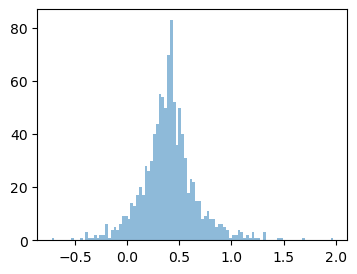

In [ ]:
# if we look at one of the samples, we can see that it is a laplace distribution
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.hist(_samples.numpy()[:,0,0], bins=100, alpha=0.5)
plt.show()

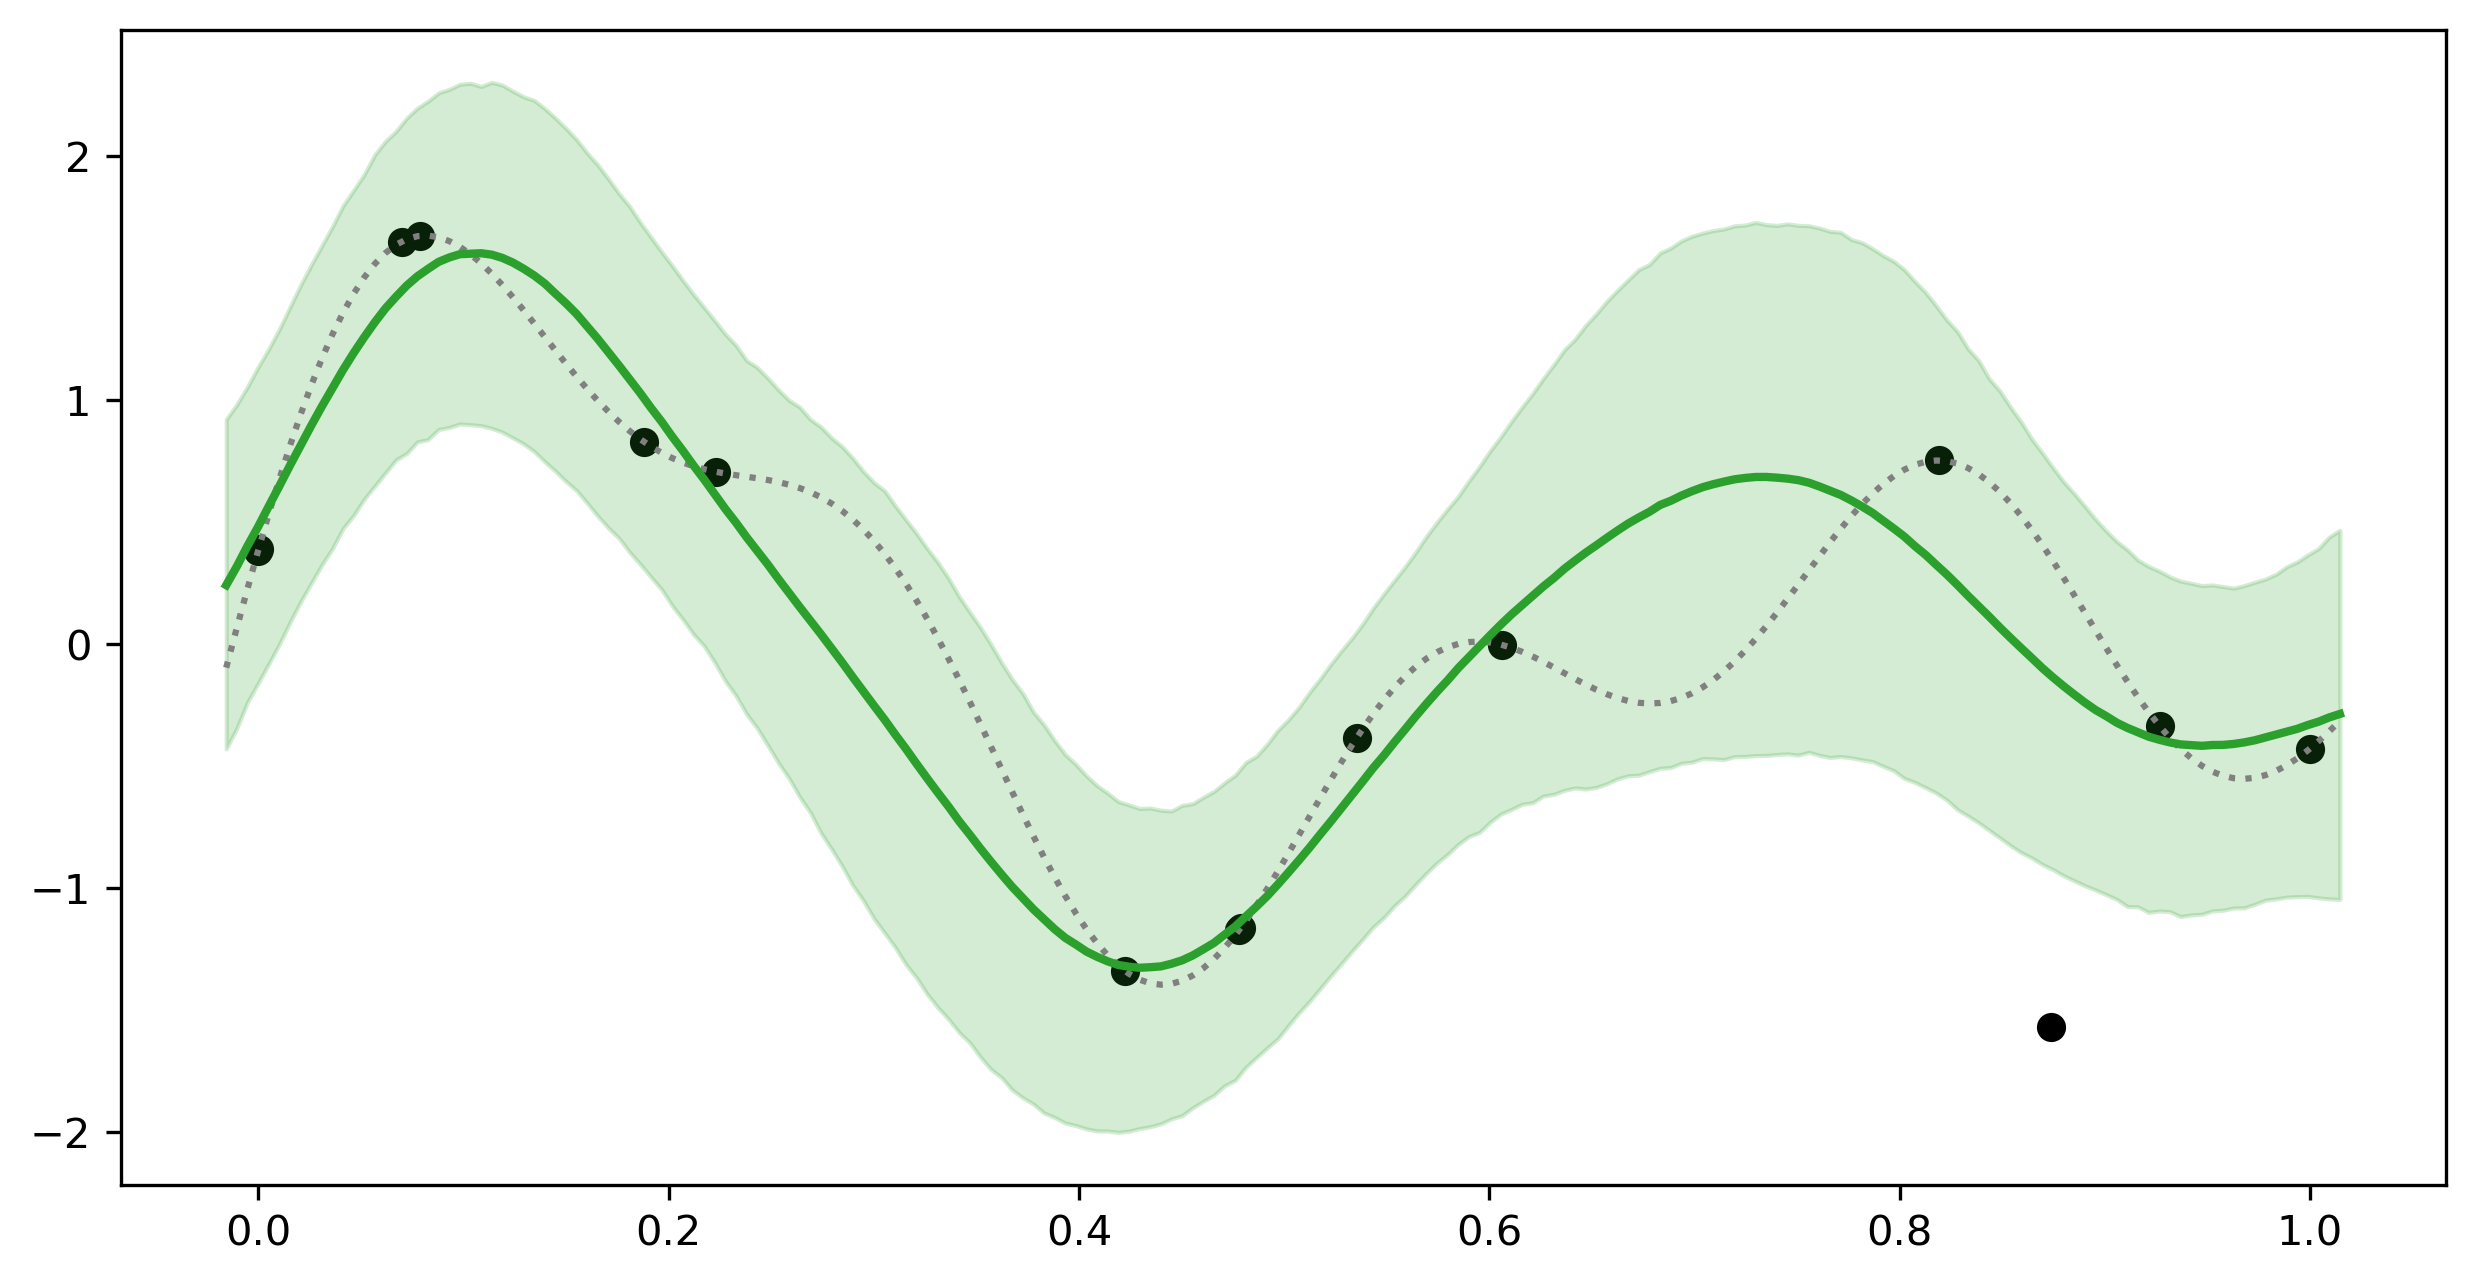

In [48]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(x_test, y_test, label="True function", color="grey", ls=":")
plt.scatter(x_train, y_train, label="Training data", color="k")

# plt.plot(x_test, mean, label="Mean prediction", color="C0", lw=2)
plt.plot(x_test, predictive_mean, label="Mean prediction", color="C2", lw=2)

plt.fill_between(
    x_test.flatten(),
    lower_quantile,
    upper_quantile,
    alpha=0.2,
    label="95% confidence interval",
    color="C2",
)